<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Paro)](#Analisis-por-grupo-de-indicadores-(paro))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [ ]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [ ]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Paro)

### Preparacion de datos

In [ ]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','ParadosReg']]

In [ ]:
df_paro = df_sel.dropna()

In [ ]:
df_paro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8541 entries, 0 to 8540
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   8541 non-null   int64  
 1   Trimestre             8541 non-null   int64  
 2   Mes                   8541 non-null   int64  
 3   Codi_Districte        8541 non-null   int64  
 4   Nom_Districte         8541 non-null   object 
 5   Codi_Barri            8541 non-null   int64  
 6   Nom_Barri             8541 non-null   object 
 7   Compraventa_Unitario  8541 non-null   float64
 8   ParadosReg            8541 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 600.7+ KB


In [ ]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_paro['Fecha'] = pd.to_datetime(df_paro['Any'].astype(str) + '-' + df_paro['Mes'].astype(str) + '-1')

In [ ]:
# Modificamos el indice del dataset por la fecha
df_paroI = df_paro.set_index('Fecha')

In [ ]:
df_paroI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg
Fecha,,,,,,,,,
2014-01-01,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588
2014-02-01,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539
2014-03-01,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572
2014-04-01,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510
2014-05-01,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [ ]:
df_paroFiltrado = df_paroI[df_paroI['Codi_Districte'] == 8]

In [ ]:
# Agrupamos los datos
df_paroBarna =df_paroFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [ ]:
df_paroBarna.head()

,Compraventa_Unitario,ParadosReg
Fecha,,
2014-01-01,1511.900000,1124.923077
2014-02-01,1511.900000,1125.153846
2014-03-01,1511.900000,1130.153846
2014-04-01,1633.069231,1111.076923
2014-05-01,1633.069231,1072.923077


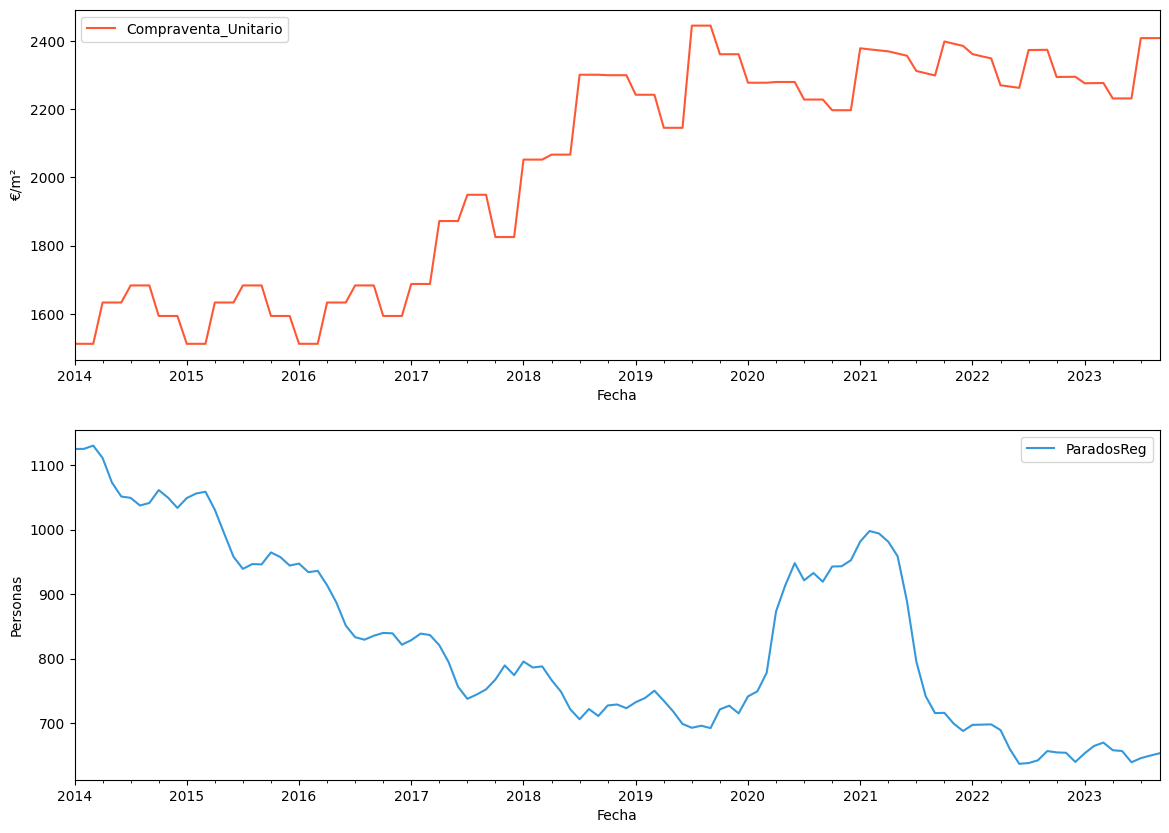

In [ ]:
fig, axes = plt.subplots(nrows = int(len(df_paroBarna.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', 'Personas']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df_paroBarna.columns, axes.flatten())):
    df_paroBarna[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [ ]:
corr=df_paroBarna.corr()
corr

,Compraventa_Unitario,ParadosReg
Compraventa_Unitario,1.000000,-0.684608
ParadosReg,-0.684608,1.000000


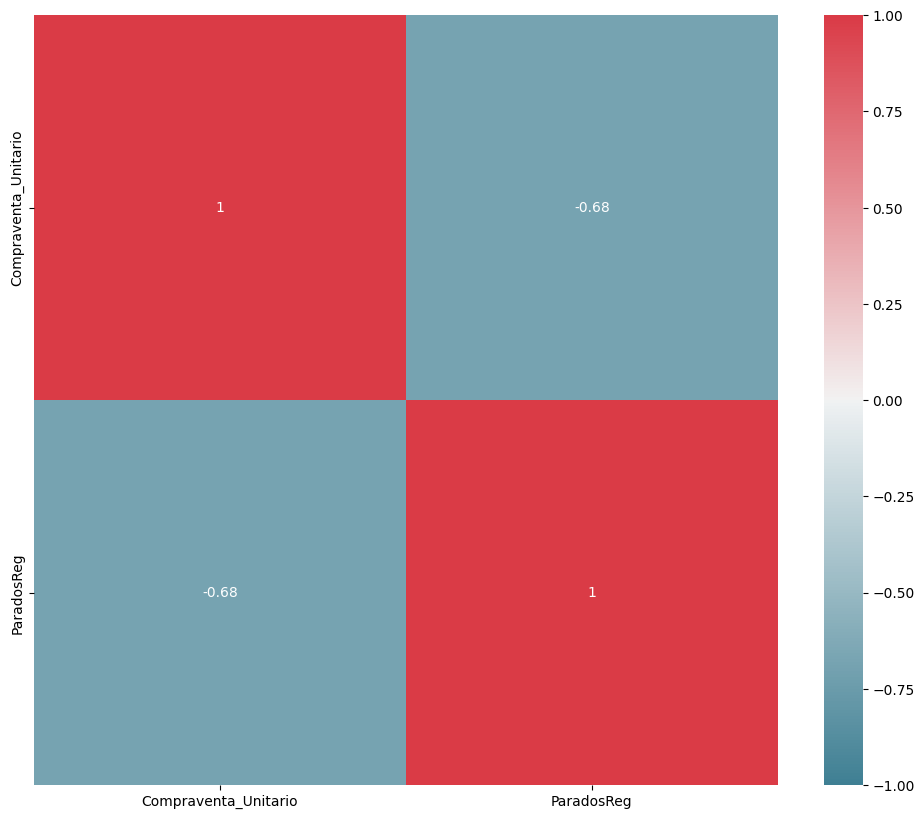

In [ ]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen algo de correlacion inversa

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [ ]:
fecha_division = '2023-01-01'

X_train, X_test = df_paroBarna[df_paroBarna.index<fecha_division], df_paroBarna[df_paroBarna.index>=fecha_division]
print(X_train.shape, X_test.shape)


(108, 2) (9, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [ ]:
import statsmodels.tsa.stattools as sts

In [ ]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.586795
Serie de tiempo ParadosReg
p-value: 0.424310


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [ ]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ParadosReg
Fecha,,
2014-02-01,0.000000,0.230769
2014-03-01,0.000000,5.000000
2014-04-01,121.169231,-19.076923
2014-05-01,0.000000,-38.153846
2014-06-01,0.000000,-21.692308


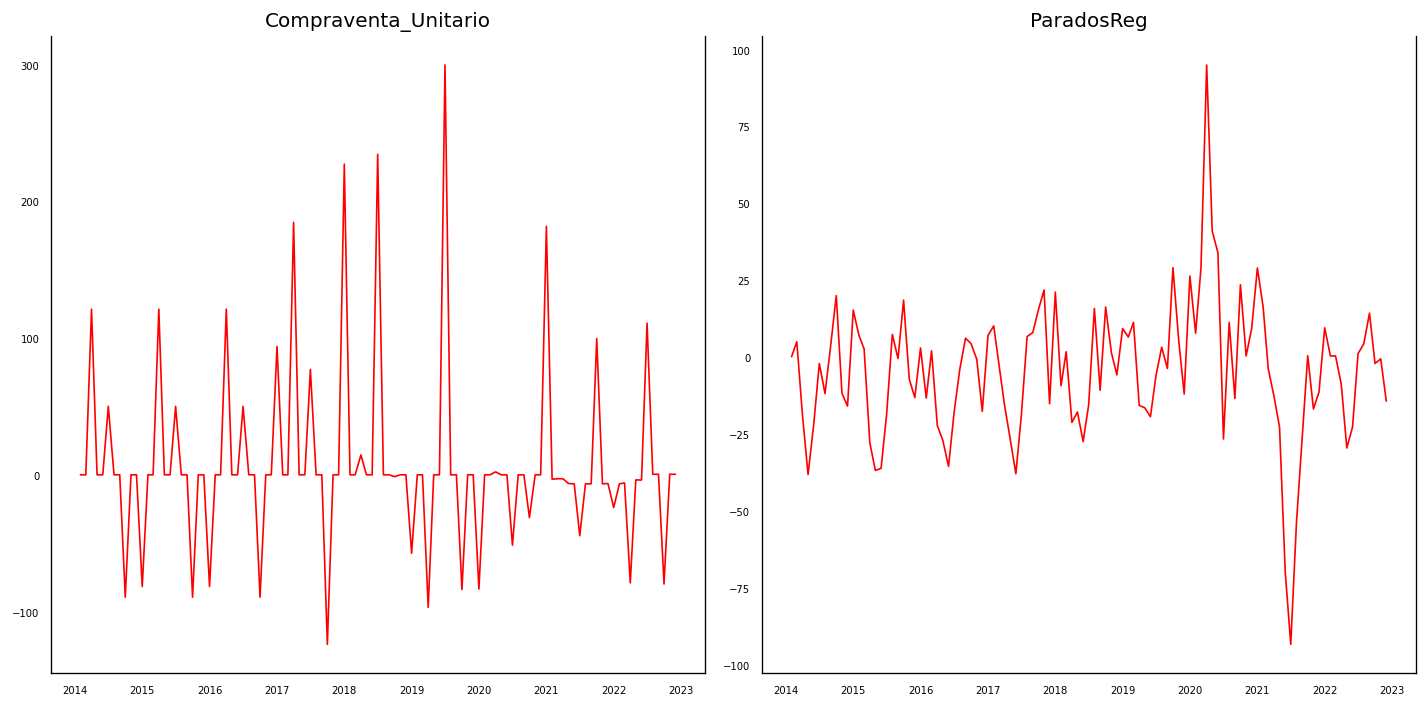

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable ParadosReg
p-value: 0.000012


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [ ]:
from statsmodels.tsa.api import VAR

In [ ]:
model = VAR(X_train_transformed)

#### Seleccionando el orden del modelo

In [ ]:
modelsel=model.select_order(29)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,14.88,14.94,2.903e+06,14.91
1,14.55,14.73*,2.086e+06*,14.62*
2,14.65,14.95,2.294e+06,14.77
3,14.63,15.06,2.269e+06,14.80
4,14.72,15.27,2.479e+06,14.94
5,14.74,15.40,2.522e+06,15.00
6,14.78,15.56,2.634e+06,15.09
7,14.85,15.76,2.852e+06,15.22
8,14.92,15.94,3.053e+06,15.33
9,14.84,15.98,2.829e+06,15.29


#### Ajustando el modelo

In [ ]:
res = model.fit(maxlags=29, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, May, 2024
Time:                     17:10:12
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.9224
Nobs:                     78.0000    HQIC:                   15.7844
Log likelihood:          -663.284    FPE:                4.33663e+06
AIC:                      14.3572    Det(Omega_mle):     1.40573e+06
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           10.708501        14.695313            0.729           0.466
L1.Compraventa_Unitario         -0.005744         0.241130           -0.024           0.981
L

La correlación entre los residuos de "Compraventa_Unitario" y "ParadosReg" es de 0.218227, lo que sugiere una correlación moderada entre los residuos de estas dos variables en tu modelo.


In [ ]:
X_train.columns

Index(['Compraventa_Unitario', 'ParadosReg'], dtype='object')

###### Causalidad de Granger

In [ ]:
grangercaus=res.test_causality(['ParadosReg'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.410,1.766,0.159,"(29, 38)"


In [ ]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['ParadosReg'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.018,1.766,0.474,"(29, 38)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,ParadosReg_x
Compraventa_Unitario_y,1.0000,0.0203
ParadosReg_y,0.0011,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [ ]:
residuals=res.resid

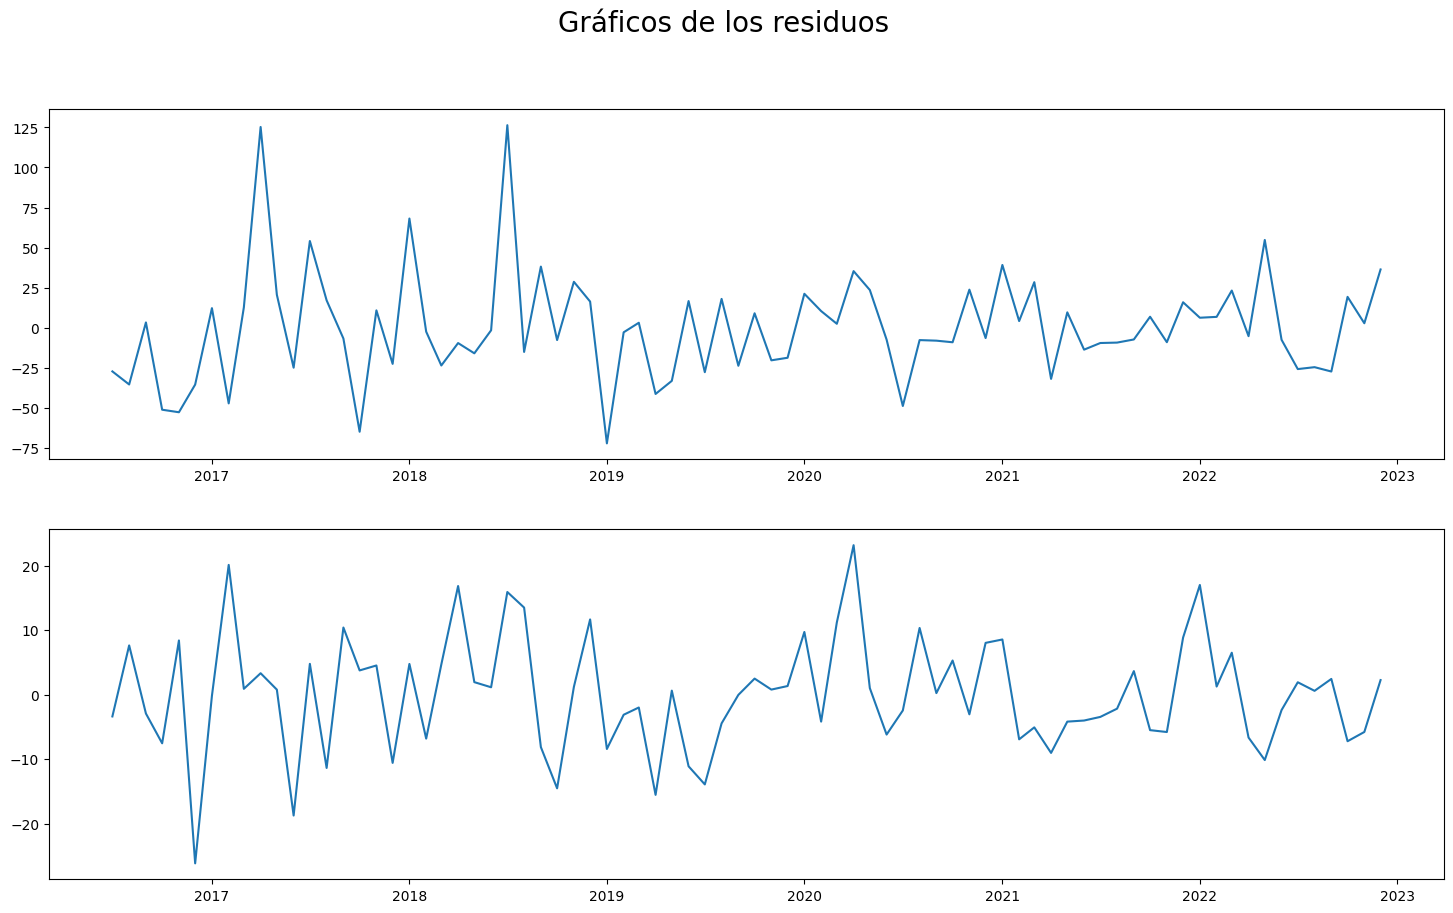

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [ ]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[1.0258127576098119e-13, 9.461830628109162e-13]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


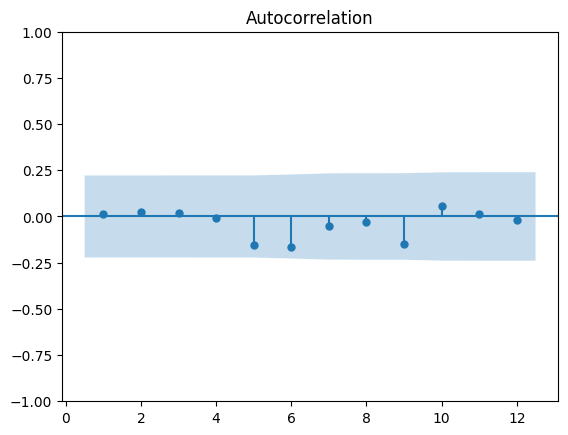

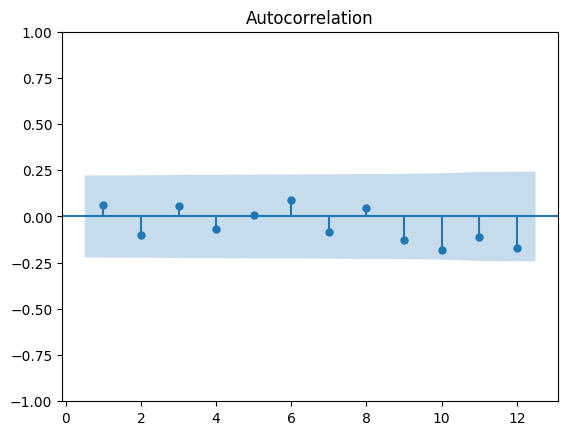

In [ ]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


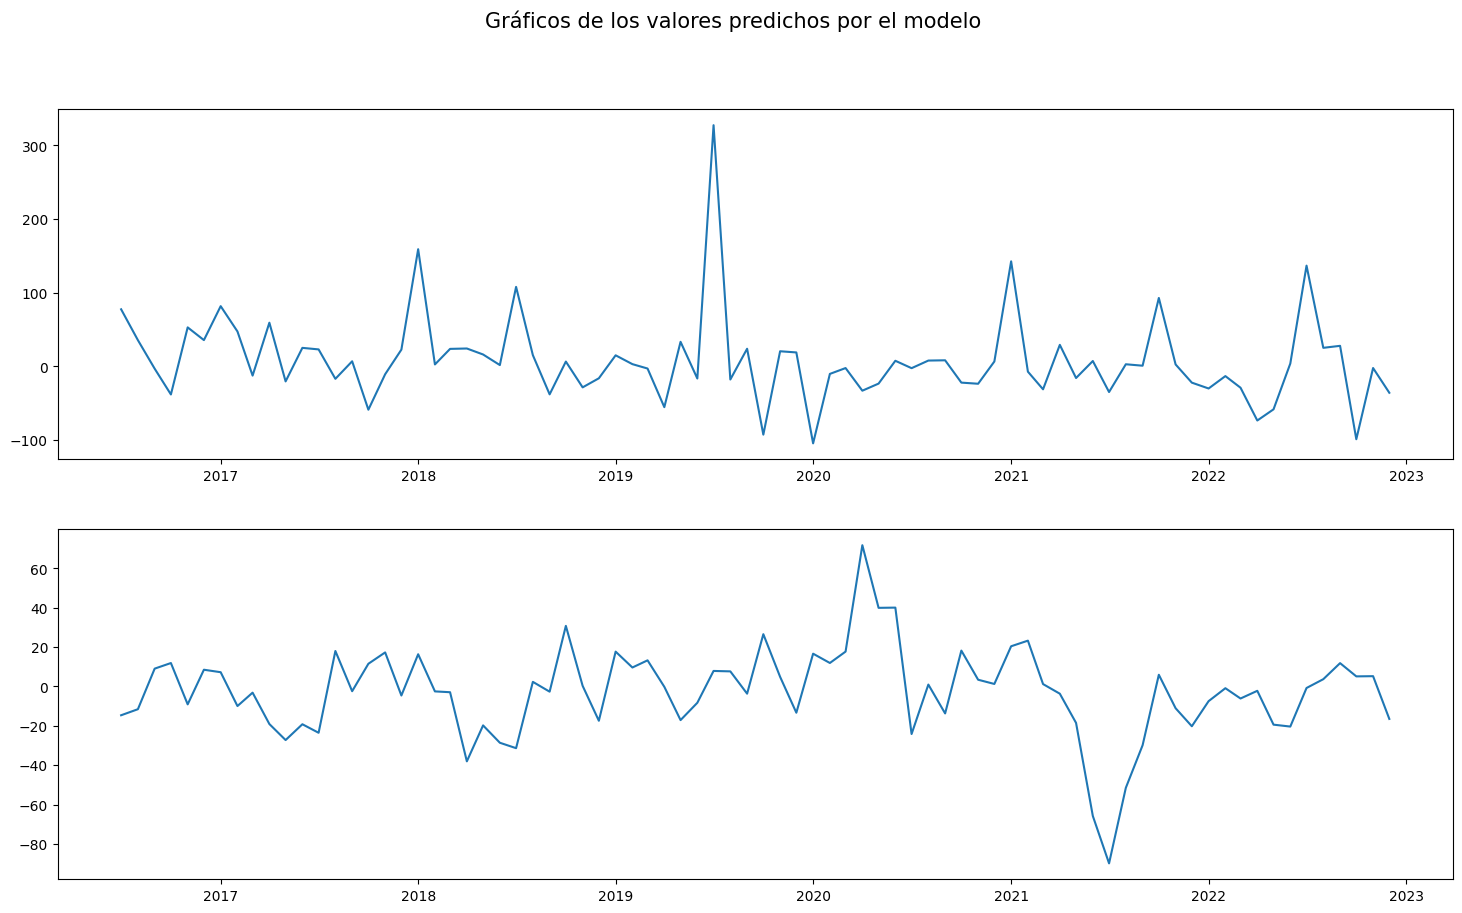

In [ ]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [ ]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=9)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 29
Predicciones:


,Compraventa_Unitario_pred,ParadosReg_pred
Fecha,,
2023-01-01,-121.903859,82.344100
2023-02-01,-135.120114,73.767537
2023-03-01,-4.268030,139.115710
2023-04-01,-2.437547,117.724886
2023-05-01,41.987935,104.238295
2023-06-01,49.607271,32.306633
2023-07-01,257.950393,0.776766
2023-08-01,131.484734,-49.902724
2023-09-01,184.609127,-127.611883


<Figure size 1200x1000 with 0 Axes>

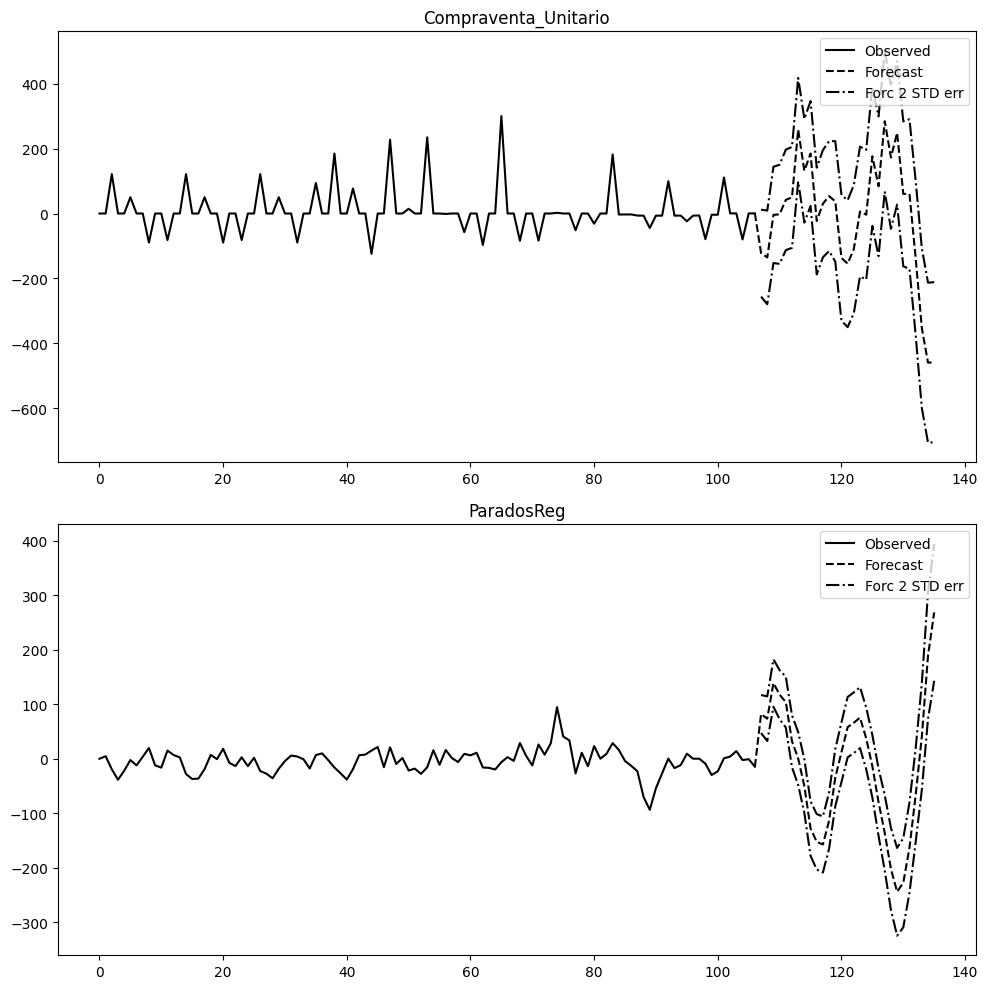

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [ ]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [ ]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,ParadosReg
Fecha,,
2023-01-01,2173.318912,722.036407
2023-02-01,2038.198798,795.803944
2023-03-01,2033.930768,934.919654
2023-04-01,2031.493221,1052.644540
2023-05-01,2073.481157,1156.882835
2023-06-01,2123.088427,1189.189468
2023-07-01,2381.038820,1189.966234
2023-08-01,2512.523554,1140.063510
2023-09-01,2697.132682,1012.451627


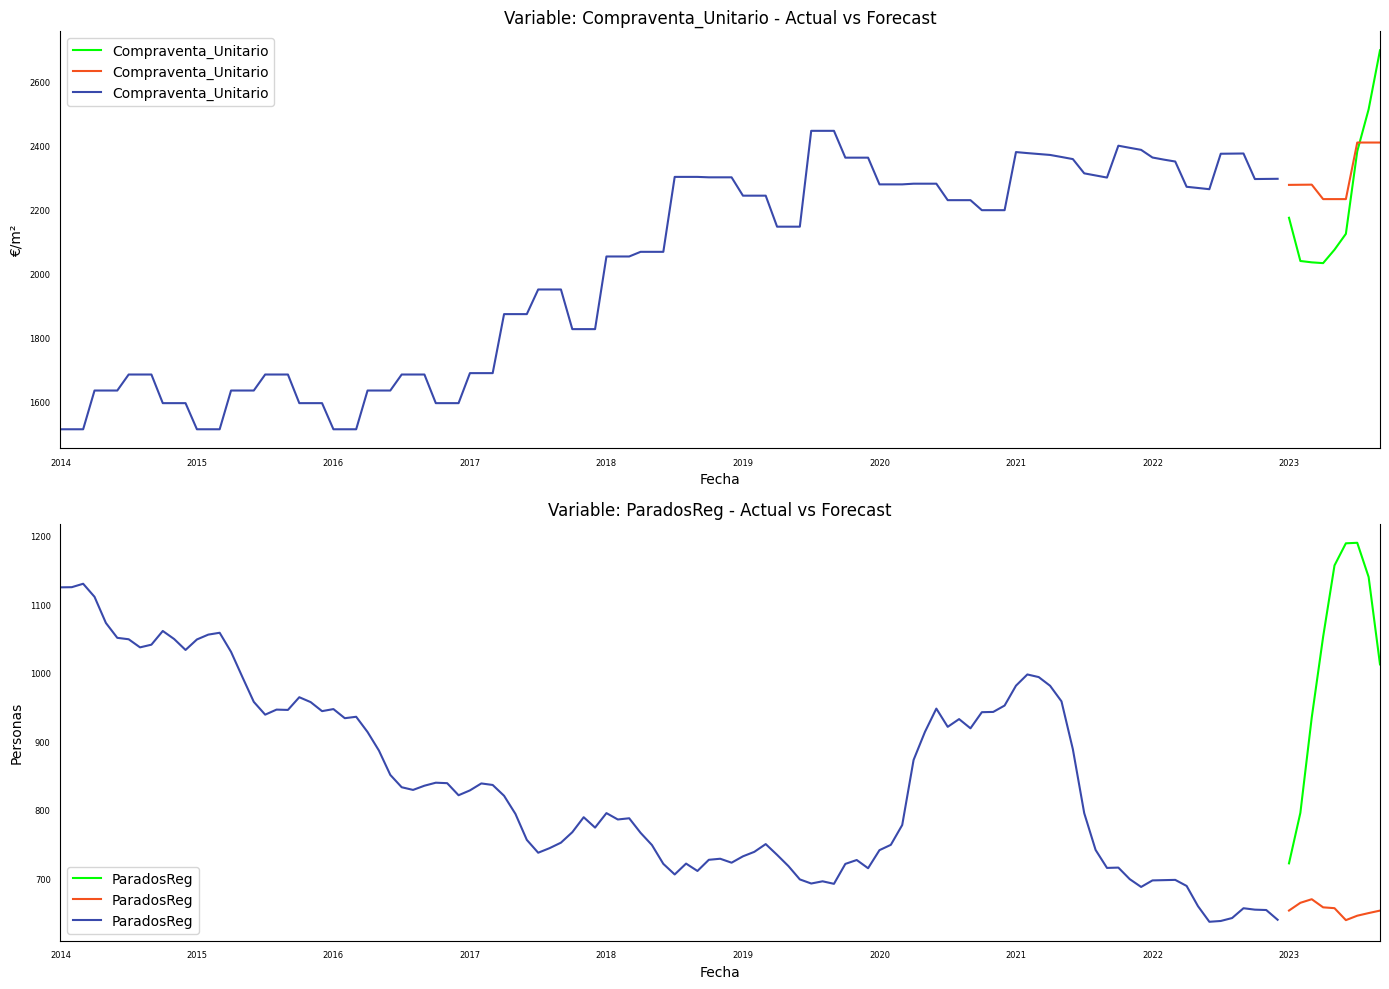

In [ ]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Personas']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
for i in ['Compraventa_Unitario','ParadosReg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 33127.038882780544
MAE is : 163.4698121613372
RMSE is : 182.00834838759607
MAPE is : 7.113888404821275
R2 is : -4.873679293754535

Evaluation metric for ParadosReg
Evaluation metric results:-
MSE is : 163019.10814904582
MAE is : 367.2090330176887
RMSE is : 403.75624843344013
MAPE is : 56.33993977907009
R2 is : -2127.961159413211



- Para "Compraventa_Unitario", el R2 es negativo, lo que indica un ajuste deficiente del modelo. Además, el valor de MAPE es relativamente bajo, lo que sugiere que las predicciones del modelo para esta variable son más precisas en comparación con otras métricas.

- Para "ParadosReg", el R2 también es negativo, lo que indica un ajuste deficiente del modelo. El valor de MAPE es alto, lo que sugiere que las predicciones del modelo para esta variable pueden no ser tan precisas y pueden estar sujetas a errores considerables.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 265.33942258951294
Root mean squared error: 313.1662074935819


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [ ]:
fecha_division = '2023-01-01'

X_train, X_test = df_paroBarna[df_paroBarna.index<fecha_division], df_paroBarna[df_paroBarna.index>=fecha_division]
print(X_train.shape, X_test.shape)

(108, 2) (9, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [ ]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.586795
Serie de tiempo ParadosReg
p-value: 0.424310


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [ ]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,ParadosReg
Fecha,,
2014-02-01,0.000000,0.230769
2014-03-01,0.000000,5.000000
2014-04-01,121.169231,-19.076923
2014-05-01,0.000000,-38.153846
2014-06-01,0.000000,-21.692308


In [ ]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable ParadosReg
p-value: 0.000012


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(X_train_transformed[['Compraventa_Unitario', 'ParadosReg']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  45.51     > 12.3212   =>   True
ParadosReg >  12.56     > 4.1296    =>   True


Los resultados del test de Cointegracion entre las dos series temporales son satisfactorios.

Para "Compraventa_Unitario", el valor del estadístico de prueba es 45.51, lo cual es mucho mayor que el valor crítico de 12.3212 al 95% de confianza. Esto indica que hay evidencia significativa de cointegración para esta variable.

Para "Participacion", el valor del estadístico de prueba es 12.56, nuevamente mucho mayor que el valor crítico de 4.1296 al 95% de confianza. Esto también indica que hay evidencia significativa de cointegración para esta variable.

A pesar de las fluctuaciones a corto plazo, ambas variables tienden a moverse juntas en el largo plazo. Esto es importante para la modelización y el análisis de series temporales, ya que proporciona información sobre la relación a largo plazo entre las variables y puede ayudar en la construcción de modelos más precisos y en la formulación de políticas adecuadas.

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [ ]:
import pmdarima as pm

In [ ]:

pq = []
for name in ['Compraventa_Unitario', 'ParadosReg']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1198.697, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1200.697, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1200.697, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1202.699, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1199.327, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.545 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : ParadosReg
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=977.381, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=938.431, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=951.442, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=940.270, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=940.334, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]     

#####Seleccion del modelo

In [ ]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [ ]:
pq

[(0, 0, 0), (1, 0, 0)]

Para la serie temporal de compraventa unitario

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

Para la serie temporal de parados registrados

- *p=1:* Indica que se incluyen términos autoregresivos hasta el primer orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a sus valores en un periodo anterior.

- *q=0: *Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE ParadosReg'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'ParadosReg']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 9)
        inv_res = inverse_diff(df_paroBarna[['Compraventa_Unitario', 'ParadosReg']] , result, True)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Paradosrmse = np.sqrt(metrics.mean_squared_error(X_test['ParadosReg'], inv_res.ParadosReg))
        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Paradosrmse]


Grid Search Started
 Running for (1, 0, 0)


In [ ]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE ParadosReg'] )

,p,q,RMSE Compraventa_Unitario,RMSE ParadosReg
0,1.0,0.0,283.391927,138.90315


#### Pronósticos a futuro


In [ ]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','ParadosReg']], order=(0,2)).fit(disp=False)
result = model.forecast(steps = 9)

In [ ]:
result

,Compraventa_Unitario,ParadosReg
2023-01-01,13.012534,3.250642
2023-02-01,-3.405431,4.320094
2023-03-01,0.065990,-0.001436
2023-04-01,0.065990,-0.001436
2023-05-01,0.065990,-0.001436
2023-06-01,0.065990,-0.001436
2023-07-01,0.065990,-0.001436
2023-08-01,0.065990,-0.001436
2023-09-01,0.065990,-0.001436


#### Invertiendo la transformacion de los pronosticos a la escala original

In [ ]:
res = inverse_diff(df_paroBarna[['Compraventa_Unitario', 'ParadosReg']],result,True)

In [ ]:
res

,Compraventa_Unitario,ParadosReg
2023-01-01,2420.311011,647.773713
2023-02-01,2441.649796,634.426988
2023-03-01,2470.309682,616.532022
2023-04-01,2506.290669,594.088816
2023-05-01,2549.592756,567.097369
2023-06-01,2600.215944,535.557683
2023-07-01,2658.160233,499.469757
2023-08-01,2723.425622,458.833590
2023-09-01,2796.012111,413.649184


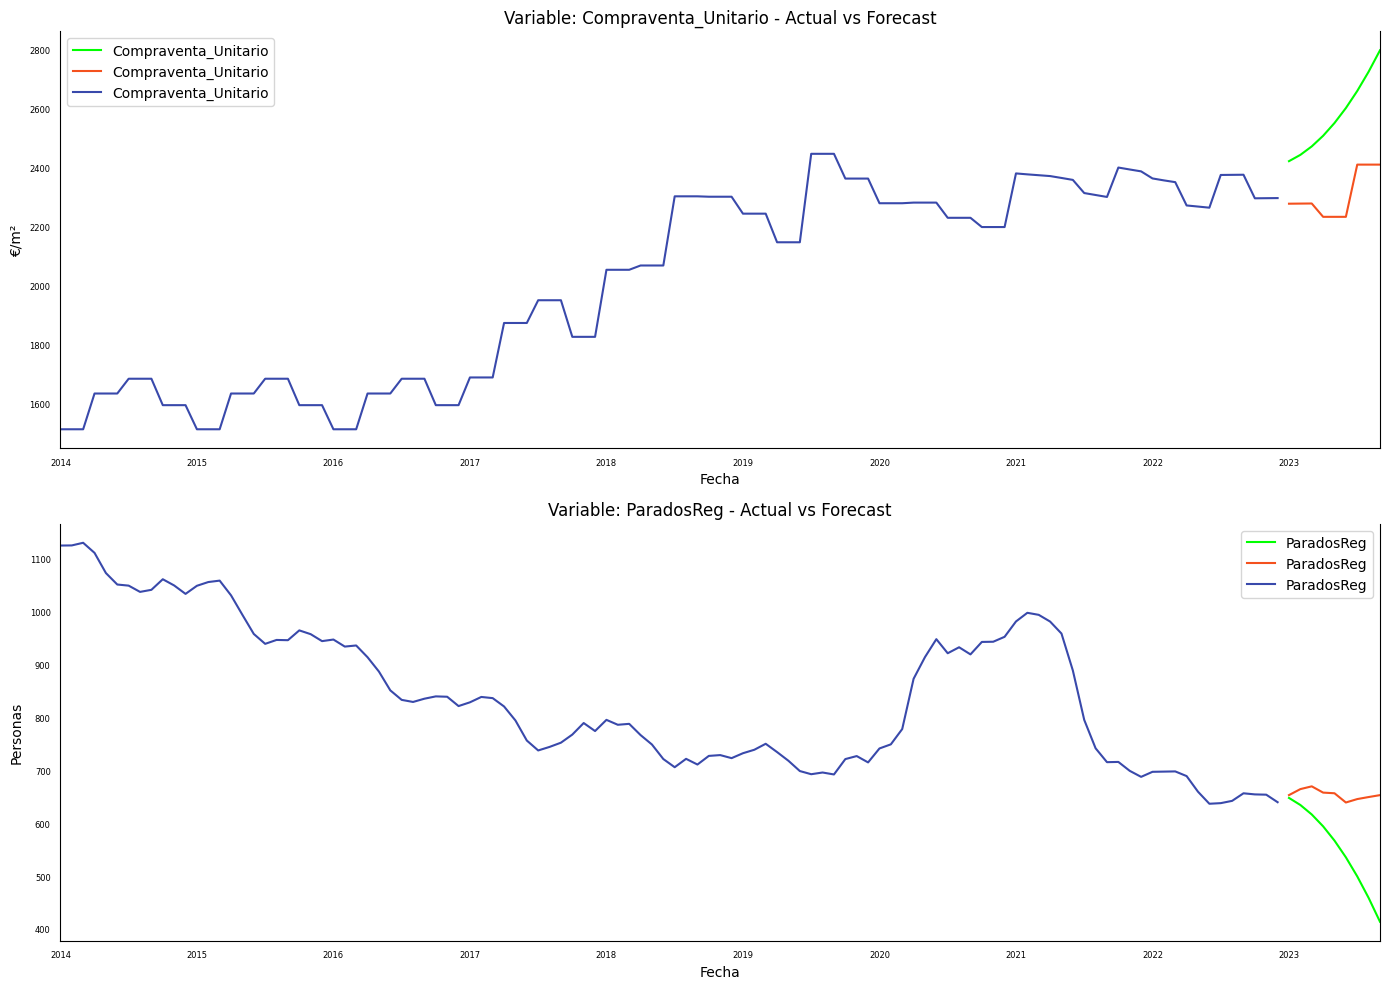

In [ ]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Personas']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
for i in ['Compraventa_Unitario','ParadosReg']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 78793.28683325602
MAE is : 268.37259354303205
RMSE is : 280.70141936451984
MAPE is : 11.62809374463876
R2 is : -12.970656991015423

Evaluation metric for ParadosReg
Evaluation metric results:-
MSE is : 15732.319543737265
MAE is : 102.40531127960855
RMSE is : 125.42854357656101
MAPE is : 15.718344393360159
R2 is : -204.4574929061164



Estas métricas indican que el modelo para "Compraventa_Unitario" tiene un rendimiento deficiente:

- El valor negativo de R2 sugiere que el modelo no se ajusta bien a los datos.
- El MAPE, aunque no es extremadamente alto, indica que las predicciones del modelo pueden ser inexactas.
- El RMSE también es alto, lo que sugiere un rendimiento deficiente del modelo.

Para "ParadosReg", el modelo también parece tener un rendimiento deficiente:

- El valor extremadamente negativo de R2 indica un ajuste muy pobre del modelo a los datos.
- El MAPE es relativamente alto, lo que sugiere que las predicciones del modelo pueden ser inexactas.
- El RMSE, aunque es más bajo que para "Compraventa_Unitario", aún indica un rendimiento deficiente del modelo.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 185.3889524113203
Root mean squared error: 217.4000993295464


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_Unitario y del paro registrado tenemos que:

- Se ha comprobado que las variables tienen correlacion inversa.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, a partir con una diferenciacion de primer orden lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido postiva, lo que quiere decir que las series temporales pueden predecirse a partir de la otras. Esto en un principio nos advierte que este modelo sera menos aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado positivo, lo que significa que las series estan relacionadas en el tiempo y que seria mas aconsejable un modelo VARMAX.

Ambos modelos no obtienen buenos resultados, principalmente por tener correlacion inversa y la irrupcion del Covid-19, mostrando mucha influencia en la serie temporal de parados registrados.

